### QUESTION 4: 

Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting MSE and significance of features.

#### Ans:

We will consider below features:

* Average impressions = total impressions / total tweets (for a particular hour)
* Average ranking score = total ranking / total tweets (for a particular hour)
* Average User Passivity(for original user) = total passivity / total tweets (for a particular hour)

In [5]:
hash_tags = ['#gohawks','#gopatriots','#nfl','#patriots','#sb49','#superbowl']

In [6]:
import pickle

def save_object(data, fileName):
    with open('pynb_data/'+fileName + ".pickle", 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def load_object(fileName):
    try:
        with open('pynb_data/'+fileName + ".pickle", 'rb') as f:
            data = pickle.load(f)
            return data
    except IOError:
        print("Could not read file: " + fileName)

In [7]:
from datetime import date, timedelta
import datetime
import pytz
import json

def getHour(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    return d.hour

def getHourAsKey(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    return "{}:{}:{}:{}".format(d.year,d.month,d.day,d.hour)

def getDayAsKey(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    return "{}:{}:{}".format(d.year,d.month,d.day)

#https://stackoverflow.com/questions/2315032/how-do-i-find-missing-dates-in-a-list-of-sorted-dates
def getAllDays(dayStrList):
    dayList = [ datetime.datetime.strptime(x, '%Y:%m:%d') for x in dayStrList ]    
    irange = [i for i in range((dayList[-1] - dayList[0]).days)]
    irange.append(irange[-1]+1)    
    allDaysList = sorted(list(set(dayList[0] + timedelta(x) for x in irange)))
    allDayStrList = [ ('{}:{}:{}'.format(d.year,d.month,d.day)) for d in allDaysList ]
    return allDayStrList

# https://arxiv.org/pdf/1401.2018v2.pdf
def getUserPassivity(user,ts):
    createdDateTimeObj = datetime.datetime.strptime(user['created_at'],"%a %b %d %H:%M:%S %z %Y")
    created = datetime.datetime.fromtimestamp(createdDateTimeObj.timestamp())
    d = datetime.datetime.fromtimestamp(ts)
    td = (created - d).days
    statuses_count = user['statuses_count']
    return td/(1.0+statuses_count)
    
def getFeatures(hash_tag):
    hourToTweets = {}
    hourToRetweets = {}
    hourToFollowerCount = {}
    hourToMaxFollowers = {}
    hourToUserPassivitySum = {}
    hourToRankingMetricSum = {}
    hourToImpressionsMetricSum = {}
    dayDict = {}
    features = []
    labels = []
    
    filename = 'data/tweets_'+tag+'.txt'
    with open(filename) as f:
        for line in f:
            json_object = json.loads(line)
            timestamp = json_object['citation_date']
            dayDict[getDayAsKey(timestamp)]=1        
            key = getHourAsKey(timestamp)
            
            if key not in hourToUserPassivitySum.keys():
                hourToUserPassivitySum[key]=0.0
            hourToUserPassivitySum[key]+=getUserPassivity(json_object['tweet']['user'],timestamp)
            
            if key not in hourToRankingMetricSum.keys():
                hourToRankingMetricSum[key]=0.0
            hourToRankingMetricSum[key]+=json_object['metrics']['ranking_score']
            
            if key not in hourToImpressionsMetricSum.keys():
                hourToImpressionsMetricSum[key]=0.0
            hourToImpressionsMetricSum[key]+=json_object['metrics']['impressions']
            
            if key not in hourToTweets.keys():
                hourToTweets[key]=0
            hourToTweets[key]+=1
            
            retweetCount = json_object['metrics']['citations']['total']        
            
            if key not in hourToRetweets.keys():
                hourToRetweets[key]=0
            hourToRetweets[key]+=retweetCount
        
            followerCount = json_object['author']['followers']
            if key not in hourToFollowerCount.keys():
                hourToFollowerCount[key]=0
            hourToFollowerCount[key]+=followerCount
        
            if key not in hourToMaxFollowers.keys():
                hourToMaxFollowers[key]=0
            hourToMaxFollowers[key] = max(hourToMaxFollowers[key],followerCount)
            
        dayList = getAllDays(list(dayDict.keys()))
#         print(dayList)
            
        for day in dayList:
            for h in range(0,24):
                key=day+':'+str(h)
                tweetCount = hourToTweets.get(key, 0)
                retweetCount = hourToRetweets.get(key,0)
                followerCount = hourToFollowerCount.get(key,0)
                maxFollowers = hourToMaxFollowers.get(key,0)
                if tweetCount > 0:
                    avgRanking = hourToRankingMetricSum.get(key,0)/tweetCount
                    avgImpressions = hourToImpressionsMetricSum.get(key,0)/tweetCount
                    avgUserPassivity = hourToUserPassivitySum.get(key,0)/tweetCount                
                else:
                    avgRanking = 0
                    avgImpressions = 0
                    avgUserPassivity = 0

                feature = [tweetCount, retweetCount, followerCount, maxFollowers, avgRanking,avgImpressions,avgUserPassivity, h]
                features.append(feature)
                
                nexthour = datetime.datetime.strptime(key, '%Y:%m:%d:%H') + timedelta(hours=1)
                nexthourkey = "{}:{}:{}:{}".format(nexthour.year,nexthour.month,nexthour.day,nexthour.hour)
                labels.append(hourToTweets.get(nexthourkey,0))
                
    return features,labels

In [8]:
for tag in hash_tags:
    print("Started building feature vectors for {}".format(tag))
    features,labels = getFeatures(tag)
    save_object(features,'q4features_{}'.format(tag))
    save_object(labels,'q4labels_{}'.format(tag))
    print("Finished building feature vectors for {}".format(tag))

Started building feature vectors for #gohawks
Finished building feature vectors for #gohawks
Started building feature vectors for #gopatriots
Finished building feature vectors for #gopatriots
Started building feature vectors for #nfl
Finished building feature vectors for #nfl
Started building feature vectors for #patriots
Finished building feature vectors for #patriots
Started building feature vectors for #sb49
Finished building feature vectors for #sb49
Started building feature vectors for #superbowl
Finished building feature vectors for #superbowl


In [10]:
import statsmodels.api as sm

for tag in hash_tags:
    print('\nLinear Regression Model for {}'.format(tag))
    X = load_object('q4features_{}'.format(tag))
    y = load_object('q4labels_{}'.format(tag))
    
#https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b
    X = sm.add_constant(X)
    
    model = sm.OLS(y,X)
    results = model.fit()
#     print(results.pvalues)
    print(results.summary())
    print('---'*20)
    print('\n\n')


Linear Regression Model for #gohawks
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     59.69
Date:                Wed, 13 Mar 2019   Prob (F-statistic):           1.00e-68
Time:                        22:54:53   Log-Likelihood:                -4345.7
No. Observations:                 528   AIC:                             8709.
Df Residuals:                     519   BIC:                             8748.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -

### QUESTION 5: 
For each of the top 3 features (i.e. with the smallest p-values) in your mea- surements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that feature, using all the samples you have extracted, and analyze it.
Do the regression coefficients agree with the trends in the plots? If not, why?


Most important features(lowest p-values) for #gohawks
[8 0 7 4]
hr


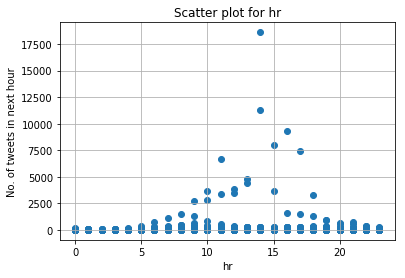

avgUserPassivity


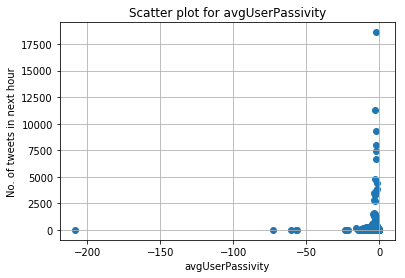

maxFollowers


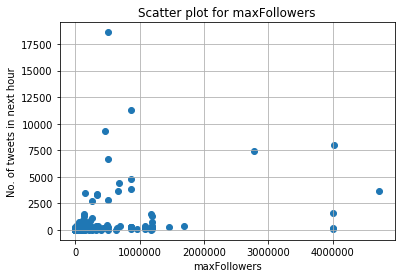

------------------------------------------------------------




Most important features(lowest p-values) for #gopatriots
[8 4 0 7]
hr


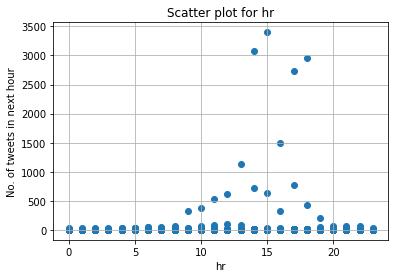

maxFollowers


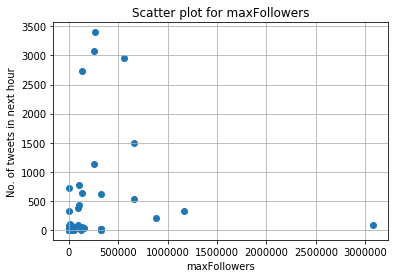

avgUserPassivity


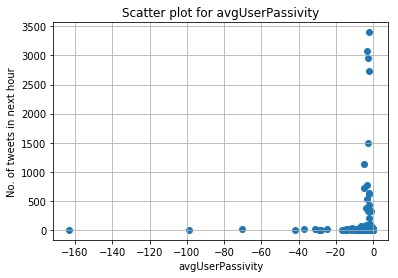

------------------------------------------------------------




Most important features(lowest p-values) for #nfl
[5 0 8 6]
avgRanking


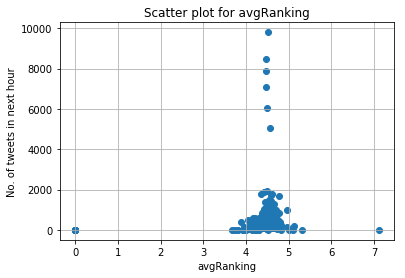

hr


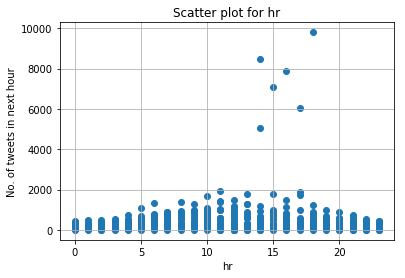

avgImpressions


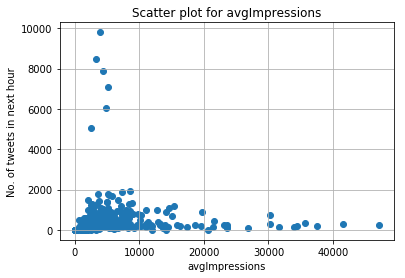

------------------------------------------------------------




Most important features(lowest p-values) for #patriots
[8 0 7 5]
hr


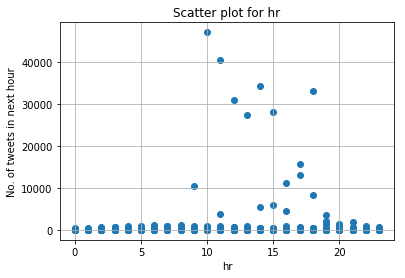

avgUserPassivity


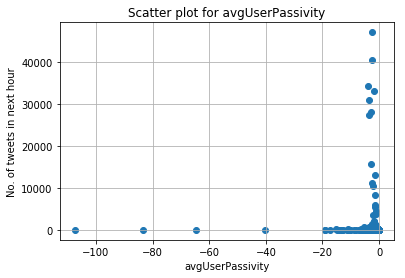

avgRanking


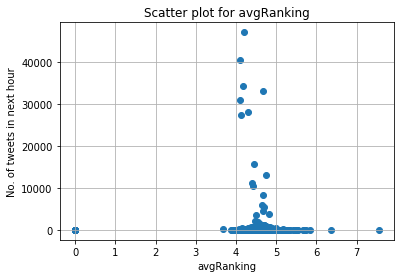

------------------------------------------------------------




Most important features(lowest p-values) for #sb49
[8 0 5 7]
hr


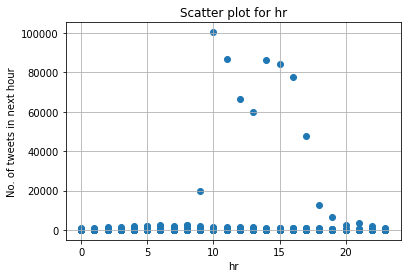

avgRanking


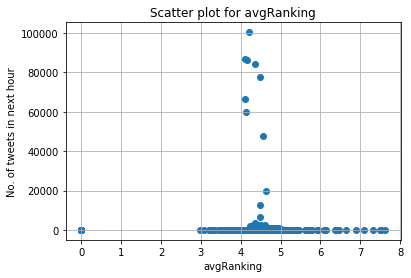

avgUserPassivity


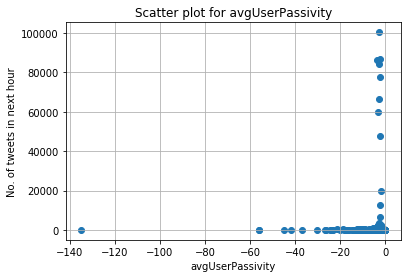

------------------------------------------------------------




Most important features(lowest p-values) for #superbowl
[7 8 5 0]
avgUserPassivity


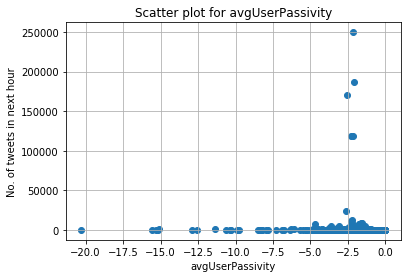

hr


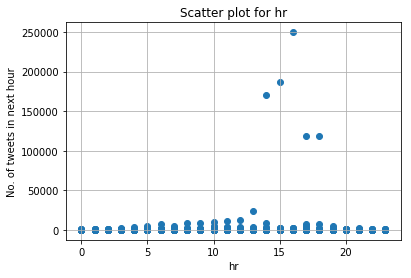

avgRanking


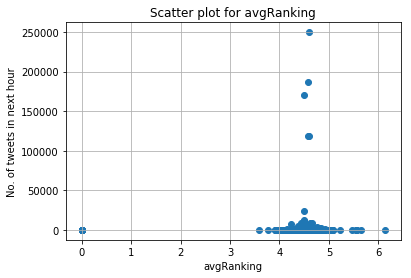

------------------------------------------------------------





In [27]:
import numpy as np
import matplotlib.pyplot as plt

index_to_feature = ['tweetCount', 'retweetCount', 'followerCount', 'maxFollowers', 'avgRanking','avgImpressions','avgUserPassivity','hr']

def plotScatter(features,labels,index):
    if index==0:
        return
    
    x = [f[index] for f in features]
    y = labels
    plt.scatter(x, y)
    plt.xlabel(index_to_feature[index-1])
    plt.ylabel("No. of tweets in next hour")
    plt.title("Scatter plot for "+index_to_feature[index-1])
    plt.grid()
    plt.show()

for tag in hash_tags:
    print('\nMost important features(lowest p-values) for {}'.format(tag))
    X = load_object('q4features_{}'.format(tag))
    y = load_object('q4labels_{}'.format(tag))
    X = sm.add_constant(X)
    
    model = sm.OLS(y,X)
    results = model.fit()
    a = np.array(results.pvalues)
    ind = np.argpartition(a, -4)[-4:]
    indices = ind[np.argsort(a[ind])]
    print(indices)
    for i in indices:
        if i == 0:
            continue
        print(index_to_feature[i-1])
        plotScatter(X,y,i)
    
    print('---'*20)
    print('\n\n')
